In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
r4d1 =  pd.read_csv('prices_round_4_day_1.csv', delimiter = ';')
r4d2 =  pd.read_csv('prices_round_4_day_2.csv', delimiter = ';')
r4d3 =  pd.read_csv('prices_round_4_day_3.csv', delimiter = ';')

t4d1 = pd.read_csv('trades_round_4_day_1_nn.csv', delimiter = ';')
t4d2 = pd.read_csv('trades_round_4_day_2_nn.csv', delimiter = ';')
t4d3 = pd.read_csv('trades_round_4_day_3_nn.csv', delimiter = ';')

In [3]:
r4d1_c = r4d3.copy()
coconut_data = r4d1_c[r4d1_c['product'] == 'COCONUT'].copy()
coupon_data = r4d1_c[r4d1_c['product'] == 'COCONUT_COUPON'].copy()

merged_data = pd.merge(coupon_data, coconut_data, on='timestamp', suffixes=('_coupon', '_coconut'))

In [4]:
r4d1a = merged_data.copy()

In [5]:
r4d1a

day_coupon  timestamp  product_coupon  bid_price_1_coupon  \
0              3          0  COCONUT_COUPON               619.0   
1              3        100  COCONUT_COUPON               620.0   
2              3        200  COCONUT_COUPON               620.0   
3              3        300  COCONUT_COUPON               621.0   
4              3        400  COCONUT_COUPON               621.0   
...          ...        ...             ...                 ...   
9995           3     999500  COCONUT_COUPON               577.0   
9996           3     999600  COCONUT_COUPON               577.0   
9997           3     999700  COCONUT_COUPON               575.0   
9998           3     999800  COCONUT_COUPON               575.0   
9999           3     999900  COCONUT_COUPON               575.0   

      bid_volume_1_coupon  bid_price_2_coupon  bid_volume_2_coupon  \
0                    46.0                 NaN                  NaN   
1                    32.0                 NaN                  NaN   
2                    39.0                 NaN                  NaN   
3                    42.0                 NaN                  NaN   
4                    40.0                 NaN                  NaN   
...                   ...                 ...                  ...   
9995                 45.0                 NaN                  NaN   
9996                 30.0                 NaN                  NaN   
9997                 40.0                 NaN                  NaN   
9998                 30.0                 NaN                  NaN   
9999                 43.0                 NaN                  NaN   

      bid_price_3_coupon  bid_volume_3_coupon  ask_price_1_coupon  ...  \
0                    NaN                  NaN                 621  ...   
1                    NaN                  NaN                 621  ...   
2                    NaN                  NaN                 621  ...   
3                    NaN                  NaN                 622  ...   
4                    NaN                  NaN                 622  ...   
...                  ...                  ...                 ...  ...   
9995                 NaN                  NaN                 578  ...   
9996                 NaN                  NaN                 578  ...   
9997                 NaN                  NaN                 576  ...   
9998                 NaN                  NaN                 576  ...   
9999                 NaN                  NaN                 576  ...   

      bid_price_3_coconut  bid_volume_3_coconut  ask_price_1_coconut  \
0                     NaN                   NaN                 9992   
1                     NaN                   NaN                 9991   
2                     NaN                   NaN                 9991   
3                     NaN                   NaN                 9992   
4                     NaN                   NaN                 9991   
...                   ...                   ...                  ...   
9995                  NaN                   NaN                 9884   
9996                  NaN                   NaN                 9885   
9997                  NaN                   NaN                 9884   
9998                  NaN                   NaN                 9885   
9999                  NaN                   NaN                 9883   

      ask_volume_1_coconut  ask_price_2_coconut  ask_volume_2_coconut  \
0                      209                  NaN                   NaN   
1                      114               9992.0                  57.0   
2                      135               9992.0                  57.0   
3                      138               9993.0                  43.0   
4                      172                  NaN                   NaN   
...                    ...                  ...                   ...   
9995                   141               9885.0                  66.0   
9996                  

In [6]:
def black_scholes_call(S, K, r, sigma):
    if sigma == 0:
        return max(S - K, 0)
    d1 = np.log(S / K) / sigma
    d2 = d1 - sigma
    return S * norm.cdf(d1) - K * np.exp(-r) * norm.cdf(d2)

def implied_volatility(option_price, S, K, r):
    if option_price < max(S - K, 0): 
        return np.nan
    func = lambda sigma: black_scholes_call(S, K, r, sigma) - option_price
    try:
        return brentq(func, 0.001, 5.0)
    except ValueError:
        return np.nan

def calculate_delta(S, K, r, sigma):
    if sigma == 0:
        return 1.0 if S > K else 0.0
    d1 = np.log(S / K) / sigma
    return norm.cdf(d1)

def calculate_gamma(S, K, r, sigma):
    if sigma == 0:
        return 0.0
    d1 = np.log(S / K) / sigma
    return norm.pdf(d1) / (S * sigma)

K = 10000
r = 0.0 

r4d1a['implied_volatility'] = r4d1a.apply(
    lambda row: implied_volatility(row['mid_price_coupon'], row['mid_price_coconut'], K, r), axis=1
)
r4d1a['delta'] = r4d1a.apply(
    lambda row: calculate_delta(row['mid_price_coconut'], K, r, row['implied_volatility']), axis=1
)
r4d1a['gamma'] = r4d1a.apply(
    lambda row: calculate_gamma(row['mid_price_coconut'], K, r, row['implied_volatility']), axis=1
)

fig = go.Figure()
fig.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['implied_volatility'], mode='lines', name='Implied Volatility'))
fig.update_layout(title='Implied Volatility over Time', xaxis_title='Timestamp', yaxis_title='Implied Volatility')

#fig.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['delta'], mode='lines', name='Delta', yaxis='y2'))
#fig.update_layout(title='Delta over Time', xaxis_title='Timestamp', yaxis_title='Delta')

#fig.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['gamma'], mode='lines', name='Gamma', yaxis='y3'))
#fig.update_layout(title='Gamma over Time', xaxis_title='Timestamp', yaxis_title='Gamma')

fig.show()


In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.graph_objects as go

# Define the Black-Scholes model functions
def black_scholes_call(S, K, r, sigma):
    if sigma == 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)) / sigma
    d2 = d1 - sigma
    return S * norm.cdf(d1) - K * np.exp(-r) * norm.cdf(d2)

def calculate_delta(S, K, r, sigma):
    if sigma == 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)) / sigma
    return norm.cdf(d1)

# Load the data
data = pd.read_csv('prices_round_4_day_1.csv', delimiter=';')
data = data[data['product'].isin(['COCONUT', 'COCONUT_COUPON'])]

# Extract and merge coconut and coupon data
coconut_data = data[data['product'] == 'COCONUT'][['timestamp', 'mid_price']].rename(columns={'mid_price': 'mid_price_coconut'})
coupon_data = data[data['product'] == 'COCONUT_COUPON'][['timestamp', 'mid_price']].rename(columns={'mid_price': 'mid_price_coupon'})
merged_data = pd.merge(coconut_data, coupon_data, on='timestamp')

# Calculate annualized volatility
log_returns = np.log(merged_data['mid_price_coconut'] / merged_data['mid_price_coconut'].shift(1))
sigma = -log_returns.std() * np.sqrt(432000 * 250)  # Annualize the volatility

# Polynomial Regression for Real Delta
window_size = 1
merged_data['smoothed_mid_price_coconut'] = merged_data['mid_price_coconut'].rolling(window=window_size, min_periods=1).mean()
X = merged_data['smoothed_mid_price_coconut'].values.reshape(-1, 1)
y = merged_data['mid_price_coupon'].values
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression().fit(X_poly, y)
merged_data['poly_delta'] = poly_model.coef_[1] + 2 * poly_model.coef_[2] * merged_data['smoothed_mid_price_coconut']
merged_data['smoothed_poly_delta'] = merged_data['poly_delta'].rolling(window=10, min_periods=1).mean()

# Calculate Black-Scholes Delta
K = 10000
r = 0.0
merged_data['bs_delta'] = merged_data.apply(
    lambda row: calculate_delta(row['mid_price_coconut'], K, r, sigma), axis=1
)

# Plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_data['timestamp'], y=merged_data['smoothed_poly_delta'], mode='lines', name='Smoothed Real Delta'))
fig.add_trace(go.Scatter(x=merged_data['timestamp'], y=merged_data['bs_delta'], mode='lines', name='Black-Scholes Delta', yaxis='y2'))
fig.update_layout(
    title='Comparison of Smoothed Real Delta vs. Black-Scholes Delta',
    xaxis_title='Timestamp',
    yaxis=dict(title='Smoothed Real Delta'),
    yaxis2=dict(title='Black-Scholes Delta', overlaying='y', side='right')
)
fig.show()


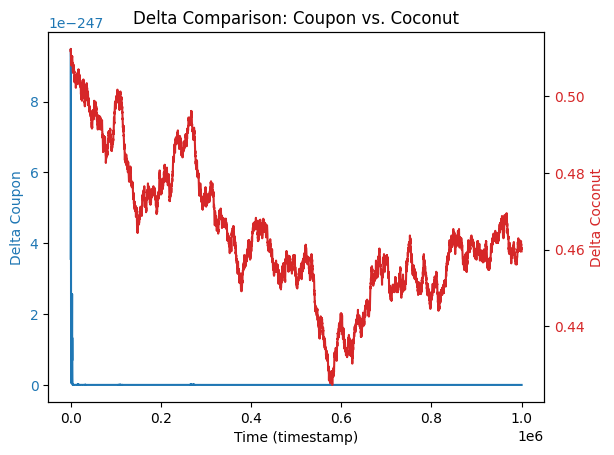

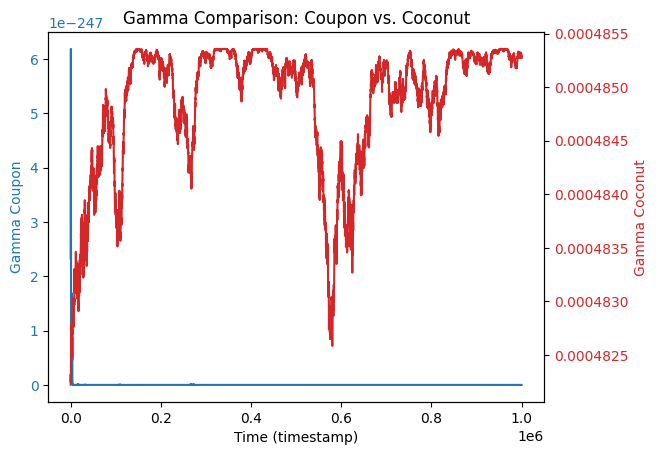

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Constants
K = 10000  # Strike price
r = 0.0  # Risk-free rate, example value
sigma = 0.1  # Volatility, example value
T = 250 / 365  # Time to maturity in years
dt = 1 / 365  # One day later

df = r4d1a.copy()

def black_scholes(S, K, T, r, sigma):
    """Returns delta and gamma using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    return delta, gamma

# Calculating delta and gamma for both actual and simulated options
df['delta_coupon'], df['gamma_coupon'] = zip(*df.apply(lambda row: black_scholes(row['mid_price_coupon'], K, T, r, sigma), axis=1))
df['delta_coconut'], df['gamma_coconut'] = zip(*df.apply(lambda row: black_scholes(row['mid_price_coconut'], K, T, r, sigma), axis=1))

# Plotting Deltas
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (timestamp)')
ax1.set_ylabel('Delta Coupon', color='tab:blue')
ax1.plot(df['timestamp'], df['delta_coupon'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Delta Coconut', color='tab:red')
ax2.plot(df['timestamp'], df['delta_coconut'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Delta Comparison: Coupon vs. Coconut')
plt.show()

# Plotting Gammas
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (timestamp)')
ax1.set_ylabel('Gamma Coupon', color='tab:blue')
ax1.plot(df['timestamp'], df['gamma_coupon'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Gamma Coconut', color='tab:red')
ax2.plot(df['timestamp'], df['gamma_coconut'], color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Gamma Comparison: Coupon vs. Coconut')
plt.show()


In [9]:
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import plotly.graph_objects as go

df = r4d1a.copy()

# Identifying local maxima and minima in the delta
order = 10  # window size for finding extrema
df['min_delta'] = df.iloc[argrelextrema(df.delta.values, np.less_equal, order=order)[0]]['delta']
df['max_delta'] = df.iloc[argrelextrema(df.delta.values, np.greater_equal, order=order)[0]]['delta']

# Simulate trades
trades = []
for i, row in df.iterrows():
    if pd.notna(row['min_delta']):
        trades.append((row['timestamp'], row['mid_price_coupon'], 'buy'))
    elif pd.notna(row['max_delta']):
        trades.append((row['timestamp'], row['mid_price_coupon'], 'sell'))

# Calculate P&L
positions = []
cum_pl = []
pl = 0
for trade in trades:
    if trade[2] == 'buy':
        positions.append(trade[1])
    elif trade[2] == 'sell' and positions:
        buy_price = positions.pop(0)
        pl += trade[1] - buy_price
        cum_pl.append(pl)

# Create plotly plots
fig = go.Figure()

# Plot for mid_price_coupon with trades
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['mid_price_coupon'], mode='lines', name='Mid Price Coupon'))
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['min_delta'], mode='markers', marker_symbol='triangle-up',
                         marker_color='green', name='Buy Points'))
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['max_delta'], mode='markers', marker_symbol='triangle-down',
                         marker_color='red', name='Sell Points'))

# Plot for cumulative P&L
trade_times, trade_prices, _ = zip(*trades)
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=trade_times, y=cum_pl, mode='lines+markers', name='Cumulative P&L'))

# Display the figures
fig.update_layout(title='Trading on Coupon Mid Price and Trades', xaxis_title='Time', yaxis_title='Price')
fig2.update_layout(title='Cumulative P&L from Trades', xaxis_title='Time', yaxis_title='P&L')

fig.show()
fig2.show()


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go

day_1 = pd.read_csv('prices_round_4_day_3.csv', delimiter=';')
#day_2 = pd.read_csv('prices_round_4_day_2.csv', delimiter=';')
#day_3 = pd.read_csv('prices_round_4_day_3.csv', delimiter=';')

all_days = day_1.copy() 
coconut_prices = all_days[all_days['product'] == 'COCONUT'][['timestamp', 'mid_price']]
coconut_prices['log_returns'] = np.log(coconut_prices['mid_price'] / coconut_prices['mid_price'].shift(1))
daily_volatility = coconut_prices['log_returns'].std()

annualized_volatility = daily_volatility * np.sqrt(250) * 100  

S0 = coconut_prices['mid_price']  
K = 10000  
T = 250 / 365
r = 0 
q = 0 
sigma = annualized_volatility 

d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

C = S0 * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
actual_call_prices = all_days[all_days['product'] == 'COCONUT_COUPON'][['timestamp', 'mid_price']]
actual_call_prices['black_scholes_price'] = C


In [11]:
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

coconut_prices['black_scholes_call'] = coconut_prices['mid_price'].apply(
    lambda S: black_scholes_call(S, K, T, r, sigma))

fig_corrected = go.Figure()
fig_corrected.add_trace(go.Scatter(x=actual_call_prices['timestamp'], y=actual_call_prices['mid_price'],
                                   mode='lines', name='Actual Call Prices',
                                   line=dict(color='blue', width=2)))
fig_corrected.add_trace(go.Scatter(x=coconut_prices['timestamp'], y=coconut_prices['black_scholes_call'],
                                   mode='lines', name='Black-Scholes Prices',
                                   line=dict(color='red', width=2),
                                   yaxis='y2'))

fig_corrected.update_layout(title='Corrected Comparison of Actual Call Prices vs. Black-Scholes Modeled Prices',
                            xaxis_title='Timestamp',
                            yaxis=dict(title='Actual Call Prices', titlefont=dict(color='blue')),
                            yaxis2=dict(title='Black-Scholes Prices', titlefont=dict(color='red'),
                                        overlaying='y', side='right'))
fig_corrected.show()


In [12]:
r4d1a.to_csv('r4d1a.csv', index=False)

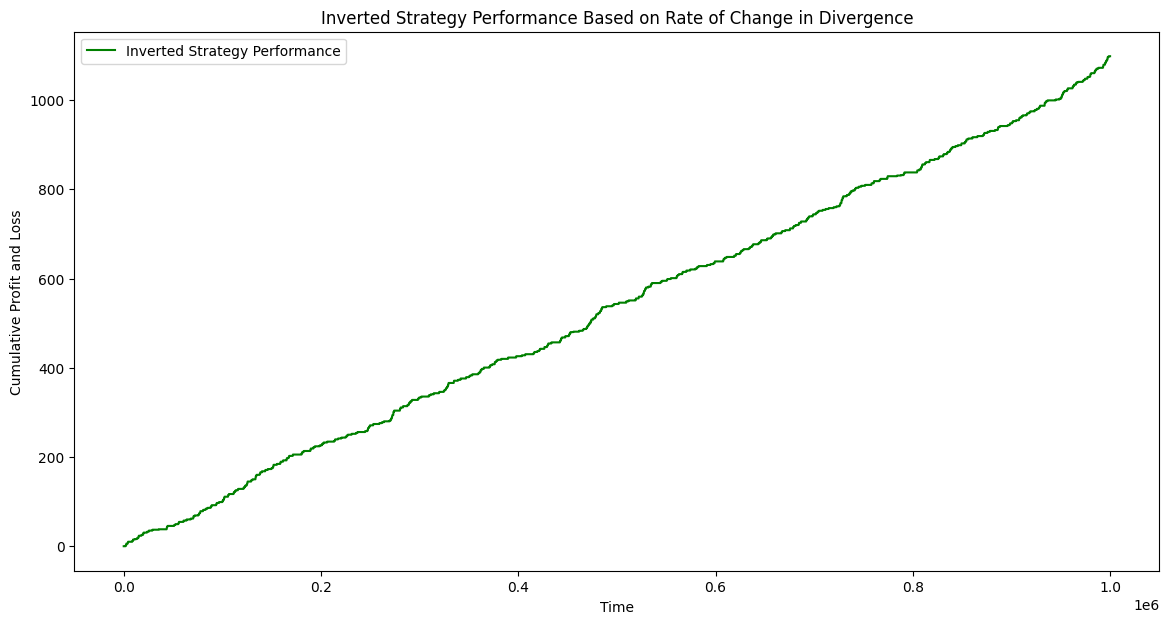

           inverted_signal  inverted_trade_result  \
timestamp                                           
999500                   0                    0.0   
999600                   0                    0.0   
999700                   0                   -0.0   
999800                   0                    0.0   
999900                   0                    0.0   

           inverted_strategy_performance  
timestamp                                 
999500                            1098.5  
999600                            1098.5  
999700                            1098.5  
999800                            1098.5  
999900                            1098.5  


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


to_plot_resampled = pd.read_csv('r4d1a.csv')
to_plot_resampled.set_index('timestamp', inplace=True)


to_plot_resampled['log_returns'] = np.log(to_plot_resampled['mid_price_coconut'] / to_plot_resampled['mid_price_coconut'].shift(1))
daily_volatility = to_plot_resampled['log_returns'].std()

annualized_volatility = daily_volatility * np.sqrt(250) * 100  

S0 = to_plot_resampled['mid_price_coconut']  
K = 10000  
T = 250 / 365
r = 0 
q = 0 
sigma = annualized_volatility 

def norm_cdf(x):
    a1, a2, a3, a4, a5 = 0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429
    g = 1 / np.sqrt(2 * np.pi)
    
    k = 1 / (1 + 0.2316419 * np.abs(x))
    cdf_approx = 1 - g * np.exp(-x**2 / 2) * (a1 * k + a2 * k**2 + a3 * k**3 + a4 * k**4 + a5 * k**5)
    
    if x >= 0:
        return cdf_approx
    else:
        return 1 - cdf_approx

def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * np.exp(-q * T) * norm_cdf(d1) - K * np.exp(-r * T) * norm_cdf(d2)
    return call_price

"""
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price
"""
    
to_plot_resampled['black_scholes_price'] = to_plot_resampled['mid_price_coconut'].apply(
    lambda S: black_scholes_call(S, K, T, r, sigma))

#to_plot_resampled['black_scholes_price'] = 507.53

to_plot_resampled['divergence'] = to_plot_resampled['mid_price_coupon'] - to_plot_resampled['black_scholes_price']
to_plot_resampled['divergence_change'] = to_plot_resampled['divergence'].diff()
threshold = to_plot_resampled['divergence_change'].std() * 2
to_plot_resampled['signal'] = 0
to_plot_resampled.loc[to_plot_resampled['divergence_change'] > threshold, 'signal'] = -1  
to_plot_resampled.loc[to_plot_resampled['divergence_change'] < -threshold, 'signal'] = 1  
to_plot_resampled['inverted_signal'] = -to_plot_resampled['signal']
to_plot_resampled['inverted_trade_result'] = to_plot_resampled['inverted_signal'] * to_plot_resampled['mid_price_coupon'].diff()
to_plot_resampled['inverted_strategy_performance'] = to_plot_resampled['inverted_trade_result'].cumsum()

plt.figure(figsize=(14, 7))
plt.plot(to_plot_resampled.index, to_plot_resampled['inverted_strategy_performance'], label='Inverted Strategy Performance', color='green')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit and Loss')
plt.title('Inverted Strategy Performance Based on Rate of Change in Divergence')
plt.legend()
plt.show()

print(to_plot_resampled[['inverted_signal', 'inverted_trade_result', 'inverted_strategy_performance']].tail())


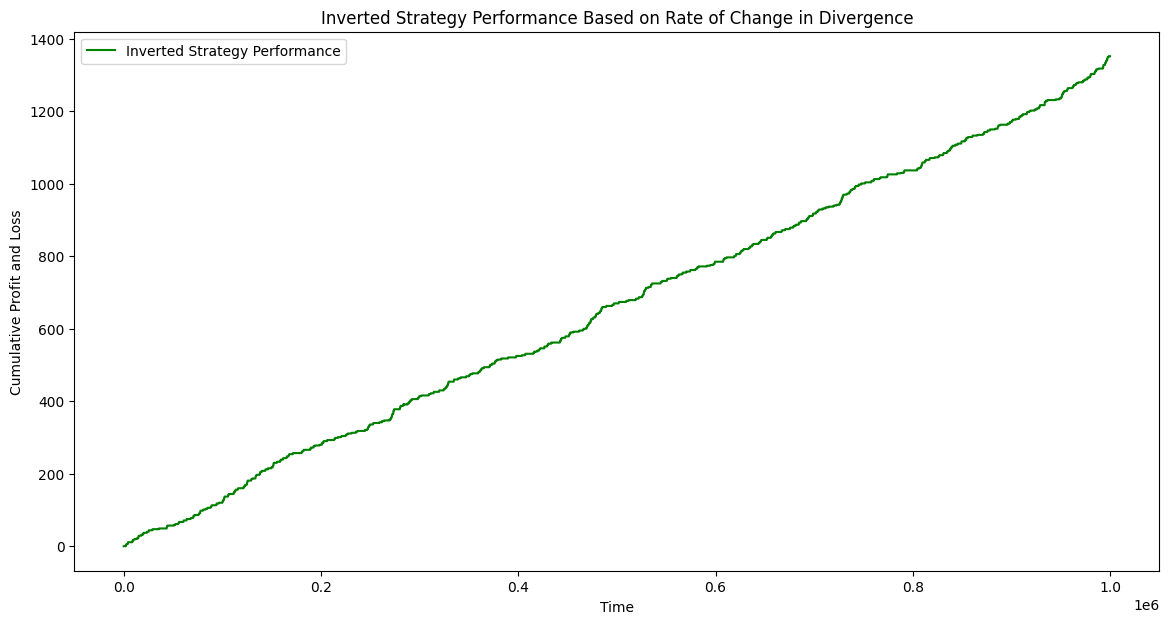

           inverted_signal  inverted_trade_result  \
timestamp                                           
999500                   0                    0.0   
999600                   0                    0.0   
999700                   0                   -0.0   
999800                   0                    0.0   
999900                   0                    0.0   

           inverted_strategy_performance  
timestamp                                 
999500                            1352.0  
999600                            1352.0  
999700                            1352.0  
999800                            1352.0  
999900                            1352.0  


In [27]:
to_plot_resampled['divergence'] = to_plot_resampled['mid_price_coupon'] - to_plot_resampled['black_scholes_price']
to_plot_resampled['divergence_change'] = to_plot_resampled['divergence'].diff()
threshold = to_plot_resampled['divergence_change'].std() * 2
to_plot_resampled['signal'] = 0
to_plot_resampled.loc[to_plot_resampled['divergence_change'] > threshold, 'signal'] = -1  
to_plot_resampled.loc[to_plot_resampled['divergence_change'] < -threshold, 'signal'] = 1  
to_plot_resampled['inverted_signal'] = -to_plot_resampled['signal']

# Calculate trade results using bid and ask prices
to_plot_resampled['trade_price'] = np.where(to_plot_resampled['inverted_signal'] > 0, to_plot_resampled['ask_price_1_coupon'], to_plot_resampled['bid_price_1_coupon'])
to_plot_resampled['inverted_trade_result'] = to_plot_resampled['inverted_signal'] * (to_plot_resampled['trade_price'].diff())
to_plot_resampled['inverted_strategy_performance'] = to_plot_resampled['inverted_trade_result'].cumsum()

# Plot the strategy performance
plt.figure(figsize=(14, 7))
plt.plot(to_plot_resampled.index, to_plot_resampled['inverted_strategy_performance'], label='Inverted Strategy Performance', color='green')
plt.xlabel('Time')
plt.ylabel('Cumulative Profit and Loss')
plt.title('Inverted Strategy Performance Based on Rate of Change in Divergence')
plt.legend()
plt.show()

print(to_plot_resampled[['inverted_signal', 'inverted_trade_result', 'inverted_strategy_performance']].tail())

In [28]:
to_plot_resampled

day_coupon  product_coupon  bid_price_1_coupon  \
timestamp                                                   
0                   3  COCONUT_COUPON               619.0   
100                 3  COCONUT_COUPON               620.0   
200                 3  COCONUT_COUPON               620.0   
300                 3  COCONUT_COUPON               621.0   
400                 3  COCONUT_COUPON               621.0   
...               ...             ...                 ...   
999500              3  COCONUT_COUPON               577.0   
999600              3  COCONUT_COUPON               577.0   
999700              3  COCONUT_COUPON               575.0   
999800              3  COCONUT_COUPON               575.0   
999900              3  COCONUT_COUPON               575.0   

           bid_volume_1_coupon  bid_price_2_coupon  bid_volume_2_coupon  \
timestamp                                                                 
0                         46.0                 NaN                  NaN   
100                       32.0                 NaN                  NaN   
200                       39.0                 NaN                  NaN   
300                       42.0                 NaN                  NaN   
400                       40.0                 NaN                  NaN   
...                        ...                 ...                  ...   
999500                    45.0                 NaN                  NaN   
999600                    30.0                 NaN                  NaN   
999700                    40.0                 NaN                  NaN   
999800                    30.0                 NaN                  NaN   
999900                    43.0                 NaN                  NaN   

           bid_price_3_coupon  bid_volume_3_coupon  ask_price_1_coupon  \
timestamp                                                                
0                         NaN                  NaN                 621   
100                       NaN                  NaN                 621   
200                       NaN                  NaN                 621   
300                       NaN                  NaN                 622   
400                       NaN                  NaN                 622   
...                       ...                  ...                 ...   
999500                    NaN                  NaN                 578   
999600                    NaN                  NaN                 578   
999700                    NaN                  NaN                 576   
999800                    NaN                  NaN                 576   
999900                    NaN                  NaN                 576   

           ask_volume_1_coupon  ...     gamma  log_returns  \
timestamp                       ...                          
0                           46  ...  0.000254          NaN   
100                         32  ...  0.000254    -0.000100   
200                         39  ...  0.000254     0.000050   
300                         42  ...  0.000253     0.000100   
400                         40  ...  0.000253    -0.000150   
...                        ...  ...       ...          ...   
999500                      45  ...  0.000251    -0.000051   
999600                      30  ...  0.000251     0.000101   
999700                      40  ...  0.000252    -0.000101   
999800                      44  ...  0.000252     0.000051   
999900                      43  ...  0.000251    -0.000152   

           black_scholes_price  divergence  divergence_change  signal  \
timestamp                                                               
0                   532.583738   87.416262                NaN       0   
100                 532.059678   88.440322           1.024061       0   
200                 532.321671   88.178329          -0.261993       0   
300                 532.845880   88.654120           0.475792       0   
400                 532.059678   

In [35]:
to_plot_resampled['cumulative_pnl'] = 0
initial_cash = 0  # Starting cash, example value
cash_balance = initial_cash
position = 0  # Starting position in the asset

pnl = []  # List to collect P&L values

for i in range(1, len(to_plot_resampled)):
    prev_row = to_plot_resampled.iloc[i - 1]
    row = to_plot_resampled.iloc[i]
    signal = prev_row['signal']
    trade_price = 0

    if signal == 1 and cash_balance > 0:  # Buy signal, check if we have cash to buy
        trade_volume = min(cash_balance // row['ask_price_1_coupon'], row['ask_volume_1_coupon'])
        trade_price = row['ask_price_1_coupon']
        position += trade_volume
        cash_balance -= trade_volume * trade_price
    elif signal == -1 and position > 0:  # Sell signal, check if we have the position to sell
        trade_volume = min(position, row['bid_volume_1_coupon'])
        trade_price = row['bid_price_1_coupon']
        position -= trade_volume
        cash_balance += trade_volume * trade_price

    pnl.append(cash_balance + position * row['mid_price_coupon'] - 100000)  # Update P&L

# Add P&L information to the dataframe
to_plot_resampled['P&L'] = pnl

# Plotting the cumulative P&L
plt.figure(figsize=(14, 7))
plt.plot(to_plot_resampled['timestamp'], to_plot_resampled['P&L'], label='Cumulative P&L', color='green')
plt.xlabel('Timestamp')
plt.ylabel('P&L')
plt.title('Cumulative P&L for Trading Strategy')
plt.legend()
plt.show()

NameError: name 'position' is not defined

In [14]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig1 = make_subplots(specs=[[{"secondary_y": True}]])
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig3 = make_subplots(specs=[[{"secondary_y": True}]])

fig1.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['mid_price_coupon'], name='Mid Price Coupon', line=dict(color='blue')), secondary_y=False)
fig1.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['implied_volatility'], name='Implied Volatility', line=dict(color='red')), secondary_y=True)
fig1.update_layout(title_text="Mid Price Coupon vs Implied Volatility")
fig1.update_xaxes(title_text="Timestamp")
fig1.update_yaxes(title_text="Mid Price Coupon", secondary_y=False)
fig1.update_yaxes(title_text="Implied Volatility", secondary_y=True)

fig2.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['mid_price_coupon'], name='Mid Price Coupon', line=dict(color='blue')), secondary_y=False)
fig2.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['delta'], name='Delta', line=dict(color='green')), secondary_y=True)
fig2.update_layout(title_text="Mid Price Coupon vs Delta")
fig2.update_xaxes(title_text="Timestamp")
fig2.update_yaxes(title_text="Mid Price Coupon", secondary_y=False)
fig2.update_yaxes(title_text="Delta", secondary_y=True)

fig3.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['mid_price_coupon'], name='Mid Price Coupon', line=dict(color='blue')), secondary_y=False)
fig3.add_trace(go.Scatter(x=r4d1a['timestamp'], y=r4d1a['gamma'], name='Gamma', line=dict(color='purple')), secondary_y=True)
fig3.update_layout(title_text="Mid Price Coupon vs Gamma")
fig3.update_xaxes(title_text="Timestamp")
fig3.update_yaxes(title_text="Mid Price Coupon", secondary_y=False)
fig3.update_yaxes(title_text="Gamma", secondary_y=True)

fig1.show()
fig2.show()
fig3.show()


In [15]:
r4d1a

day_coupon  timestamp  product_coupon  bid_price_1_coupon  \
0              3          0  COCONUT_COUPON               619.0   
1              3        100  COCONUT_COUPON               620.0   
2              3        200  COCONUT_COUPON               620.0   
3              3        300  COCONUT_COUPON               621.0   
4              3        400  COCONUT_COUPON               621.0   
...          ...        ...             ...                 ...   
9995           3     999500  COCONUT_COUPON               577.0   
9996           3     999600  COCONUT_COUPON               577.0   
9997           3     999700  COCONUT_COUPON               575.0   
9998           3     999800  COCONUT_COUPON               575.0   
9999           3     999900  COCONUT_COUPON               575.0   

      bid_volume_1_coupon  bid_price_2_coupon  bid_volume_2_coupon  \
0                    46.0                 NaN                  NaN   
1                    32.0                 NaN                  NaN   
2                    39.0                 NaN                  NaN   
3                    42.0                 NaN                  NaN   
4                    40.0                 NaN                  NaN   
...                   ...                 ...                  ...   
9995                 45.0                 NaN                  NaN   
9996                 30.0                 NaN                  NaN   
9997                 40.0                 NaN                  NaN   
9998                 30.0                 NaN                  NaN   
9999                 43.0                 NaN                  NaN   

      bid_price_3_coupon  bid_volume_3_coupon  ask_price_1_coupon  ...  \
0                    NaN                  NaN                 621  ...   
1                    NaN                  NaN                 621  ...   
2                    NaN                  NaN                 621  ...   
3                    NaN                  NaN                 622  ...   
4                    NaN                  NaN                 622  ...   
...                  ...                  ...                 ...  ...   
9995                 NaN                  NaN                 578  ...   
9996                 NaN                  NaN                 578  ...   
9997                 NaN                  NaN                 576  ...   
9998                 NaN                  NaN                 576  ...   
9999                 NaN                  NaN                 576  ...   

      ask_volume_1_coconut  ask_price_2_coconut  ask_volume_2_coconut  \
0                      209                  NaN                   NaN   
1                      114               9992.0                  57.0   
2                      135               9992.0                  57.0   
3                      138               9993.0                  43.0   
4                      172                  NaN                   NaN   
...                    ...                  ...                   ...   
9995                   141               9885.0                  66.0   
9996                   119               9886.0                  75.0   
9997                   115               9885.0                  53.0   
9998                   164                  NaN                   NaN   
9999                   131               9884.0                  69.0   

      ask_price_3_coconut  ask_volume_3_coconut  mid_price_coconut  \
0                     NaN                   NaN             9991.0   
1                     NaN                   NaN             9990.0   
2                     NaN                   NaN             9990.5   
3                     NaN                   NaN             9991.5   
4                     NaN                   NaN             9990.0   
...                   ...                   ...                ...   
9995                  NaN                   NaN             9883.5   
9996                  NaN         

In [16]:
def black_scholes_call(S, K, r, sigma):
    call_prices = np.where(sigma != 0,
                           S * norm.cdf((np.log(S / K) / sigma)) - K * np.exp(-r) * norm.cdf((np.log(S / K) / sigma) - sigma),
                           np.maximum(S - K, 0))
    return call_prices

def calculate_simulated_delta(S, K, r, sigma):
    deltas = np.where(sigma != 0,
                      norm.cdf((np.log(S / K) / sigma)),
                      np.where(S > K, 1.0, 0.0))
    return deltas

r4d1a['simulated_price'] = black_scholes_call(r4d1a['mid_price_coconut'], K, r, r4d1a['implied_volatility'])
r4d1a['simulated_delta'] = calculate_simulated_delta(r4d1a['mid_price_coconut'], K, r, r4d1a['implied_volatility'])

r4d1a['delta_difference'] = r4d1a['simulated_delta'] - r4d1a['delta']

In [17]:
# Calculate the change in option price and the change in underlying price
r4d1a['option_price_change'] = r4d1a['mid_price_coupon'].diff()
r4d1a['underlying_price_change'] = r4d1a['mid_price_coconut'].diff()

# Calculate empirical delta
# Avoid division by zero by replacing zeros with NaN, then backfilling the missing values
r4d1a['empirical_delta'] = r4d1a['option_price_change'] / r4d1a['underlying_price_change'].replace(to_replace=0, method='bfill').rolling(window=20).mean()

# Remove the first row which will have NaN values due to the diff operation
r4d1a = r4d1a.iloc[1:]

# Now r4d1a has an additional column 'empirical_delta' which is the observed delta based on price changes


C:\Users\062n\AppData\Local\Temp\ipykernel_7444\1362237518.py:7: FutureWarning:

The 'method' keyword in Series.replace is deprecated and will be removed in a future version.



In [18]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming r4d1a is your DataFrame

# Calculate percentage changes
r4d1a['option_pct_change'] = r4d1a['mid_price_coupon'].pct_change()
r4d1a['underlying_pct_change'] = r4d1a['mid_price_coconut'].pct_change()

# Drop the first row with NaN values after pct_change
r4d1a = r4d1a.dropna(subset=['option_pct_change', 'underlying_pct_change'])

# Prepare the data for regression
X = r4d1a[['underlying_pct_change']]  # Predictor
y = r4d1a['option_pct_change']       # Response

# Create and fit the regression model
model = LinearRegression()
model.fit(X, y)

# The slope coefficient represents the empirical delta
empirical_delta = model.coef_[0]

print(f"Empirical Delta: {empirical_delta}")

# If you need to add empirical delta back to the DataFrame:
r4d1a['empirical_delta'] = model.predict(X)


Empirical Delta: 7.994599465065979


C:\Users\062n\AppData\Local\Temp\ipykernel_7444\3596599555.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\062n\AppData\Local\Temp\ipykernel_7444\3596599555.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming r4d1a is the DataFrame with the relevant columns already computed

# Creating a figure with secondary y-axis for the empirical delta
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Adding the simulated delta to the primary y-axis
fig.add_trace(
    go.Scatter(x=r4d1a['timestamp'], y=r4d1a['simulated_delta'], name="Simulated Delta"),
    secondary_y=False,
)

# Adding the empirical delta to the secondary y-axis
fig.add_trace(
    go.Scatter(x=r4d1a['timestamp'], y=r4d1a['empirical_delta'], name="Empirical Delta"),
    secondary_y=True,
)

# Adding titles and labels
fig.update_layout(
    title_text="Simulated vs Empirical Delta over Time",
    xaxis_title="Timestamp"
)

fig.update_yaxes(title_text="Simulated Delta", secondary_y=False)
fig.update_yaxes(title_text="Empirical Delta", secondary_y=True)

# Showing the plot
fig.show()



In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assume r4d1a is already loaded with the correct data and 'delta_difference' has been calculated

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=r4d1a['timestamp'], y=r4d1a['mid_price_coupon'], name="Mid Price Coupon", line=dict(color='blue')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=r4d1a['timestamp'], y=r4d1a['delta_difference'], name="Delta Difference", line=dict(color='red')),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Mid Price Coupon and Delta Difference over Time"
)

# Set x-axis title
fig.update_xaxes(title_text="Timestamp")

# Set y-axes titles
fig.update_yaxes(title_text="Mid Price Coupon", secondary_y=False)
fig.update_yaxes(title_text="Delta Difference", secondary_y=True)

# Show plot
fig.show()


In [21]:
options_data = r4d1_c[r4d1_c['product'] == 'COCONUT_COUPON']
options_data

day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
1        3          0  COCONUT_COUPON        619.0          46.0          NaN   
3        3        100  COCONUT_COUPON        620.0          32.0          NaN   
5        3        200  COCONUT_COUPON        620.0          39.0          NaN   
6        3        300  COCONUT_COUPON        621.0          42.0          NaN   
9        3        400  COCONUT_COUPON        621.0          40.0          NaN   
...    ...        ...             ...          ...           ...          ...   
19990    3     999500  COCONUT_COUPON        577.0          45.0          NaN   
19992    3     999600  COCONUT_COUPON        577.0          30.0          NaN   
19995    3     999700  COCONUT_COUPON        575.0          40.0          NaN   
19996    3     999800  COCONUT_COUPON        575.0          30.0          NaN   
19998    3     999900  COCONUT_COUPON        575.0          43.0          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
1               NaN          NaN           NaN          621            46   
3               NaN          NaN           NaN          621            32   
5               NaN          NaN           NaN          621            39   
6               NaN          NaN           NaN          622            42   
9               NaN          NaN           NaN          622            40   
...             ...          ...           ...          ...           ...   
19990           NaN          NaN           NaN          578            45   
19992           NaN          NaN           NaN          578            30   
19995           NaN          NaN           NaN          576            40   
19996           NaN          NaN           NaN          576            44   
19998           NaN          NaN           NaN          576            43   

       ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
1              NaN           NaN          NaN           NaN      620.0   
3              NaN           NaN          NaN           NaN      620.5   
5              NaN           NaN          NaN           NaN      620.5   
6              NaN           NaN          NaN           NaN      621.5   
9              NaN           NaN          NaN           NaN      621.5   
...            ...           ...          ...           ...        ...   
19990          NaN           NaN          NaN           NaN      577.5   
19992          NaN           NaN          NaN           NaN      577.5   
19995          NaN           NaN          NaN           NaN      575.5   
19996          NaN           NaN          NaN           NaN      575.5   
19998          NaN           NaN          NaN           NaN      575.5   

       profit_and_loss  
1                  0.0  
3                  0.0  
5                  0.0  
6                  0.0  
9                  0.0  
...                ...  
19990              0.0  
19992              0.0  
19995              0.0  
19996              0.0  
19998              0.0  

[10000 rows x 17 columns]

In [22]:
def plot_product_prices_extended(df, product_name):
    product_df = df[df['product'] == product_name]
    fig = go.Figure()
    for i in range(1, 4): 
        if f'bid_price_{i}' in df.columns:
            fig.add_trace(go.Scatter(x=product_df['timestamp'], y=product_df[f'bid_price_{i}'],
                                     mode='lines', name=f'Bid Price {i}'))

    for i in range(1, 4):
        if f'ask_price_{i}' in df.columns:
            fig.add_trace(go.Scatter(x=product_df['timestamp'], y=product_df[f'ask_price_{i}'],
                                     mode='lines', name=f'Ask Price {i}'))
    fig.update_layout(title=f'Bid and Ask Prices for {product_name} Over Time',
                      xaxis_title='Timestamp',
                      yaxis_title='Price',
                      legend_title='Price Type')
    fig.show()

def plot_coconut_and_coupons(df):
    coconut_df = df[df['product'] == 'COCONUT']
    coupon_df = df[df['product'] == 'COCONUT_COUPON']
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=coconut_df['timestamp'], y=coconut_df['mid_price'],
                             mode='lines', name='COCONUT Mid Price',
                             yaxis='y'))
    
    fig.add_trace(go.Scatter(x=coupon_df['timestamp'], y=coupon_df['mid_price'],
                             mode='lines', name='COCONUT_COUPON Mid Price',
                             yaxis='y2'))
    
    fig.update_layout(title='COCONUT and COCONUT_COUPON Prices Over Time',
                      xaxis_title='Timestamp',
                      yaxis=dict(title='COCONUT Price', side='left'),
                      yaxis2=dict(title='COCONUT_COUPON Price', side='right', overlaying='y'),
                      legend_title='Product')
    
    fig.show()


compute delta implied vol, delta movements - is it changing - gamma - 
iv counteracts etc

In [23]:
r4d1

day  timestamp         product  bid_price_1  bid_volume_1  bid_price_2  \
0        1          0         COCONUT         9999           200          NaN   
1        1          0  COCONUT_COUPON          637            39          NaN   
2        1        100         COCONUT         9999           104       9998.0   
3        1        100  COCONUT_COUPON          637            33          NaN   
4        1        200         COCONUT         9998           133       9997.0   
...    ...        ...             ...          ...           ...          ...   
19995    1     999700  COCONUT_COUPON          681            46          NaN   
19996    1     999800  COCONUT_COUPON          681            43          NaN   
19997    1     999800         COCONUT        10134           122      10133.0   
19998    1     999900  COCONUT_COUPON          682            36          NaN   
19999    1     999900         COCONUT        10134           178          NaN   

       bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0               NaN          NaN           NaN        10001           200   
1               NaN          NaN           NaN          638            39   
2              44.0          NaN           NaN        10000           104   
3               NaN          NaN           NaN          638            33   
4              62.0          NaN           NaN         9999           133   
...             ...          ...           ...          ...           ...   
19995           NaN          NaN           NaN          682            46   
19996           NaN          NaN           NaN          682            43   
19997          65.0          NaN           NaN        10136           181   
19998           NaN          NaN           NaN          683            36   
19999           NaN          NaN           NaN        10136           120   

       ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0              NaN           NaN          NaN           NaN    10000.0   
1              NaN           NaN          NaN           NaN      637.5   
2          10001.0          44.0          NaN           NaN     9999.5   
3              NaN           NaN          NaN           NaN      637.5   
4          10000.0          62.0          NaN           NaN     9998.5   
...            ...           ...          ...           ...        ...   
19995          NaN           NaN          NaN           NaN      681.5   
19996          NaN           NaN          NaN           NaN      681.5   
19997          NaN           NaN          NaN           NaN    10135.0   
19998          NaN           NaN          NaN           NaN      682.5   
19999      10137.0          58.0          NaN           NaN    10135.0   

       profit_and_loss  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
...                ...  
19995              0.0  
19996              0.0  
19997              0.0  
19998              0.0  
19999              0.0  

[20000 rows x 17 columns]

In [24]:
t4d1

timestamp  buyer  seller          symbol   currency    price  quantity
0           800    NaN     NaN  COCONUT_COUPON  SEASHELLS    636.0         5
1           900    NaN     NaN  COCONUT_COUPON  SEASHELLS    634.0        17
2          1100    NaN     NaN  COCONUT_COUPON  SEASHELLS    635.0        17
3          1900    NaN     NaN  COCONUT_COUPON  SEASHELLS    635.0        16
4          2000    NaN     NaN  COCONUT_COUPON  SEASHELLS    637.0        14
...         ...    ...     ...             ...        ...      ...       ...
1710     997800    NaN     NaN  COCONUT_COUPON  SEASHELLS    675.0        12
1711     998200    NaN     NaN  COCONUT_COUPON  SEASHELLS    677.0        10
1712     999200    NaN     NaN  COCONUT_COUPON  SEASHELLS    677.0         7
1713     999500    NaN     NaN         COCONUT  SEASHELLS  10135.0         8
1714     999600    NaN     NaN  COCONUT_COUPON  SEASHELLS    683.0        14

[1715 rows x 7 columns]

In [25]:
def split_by_product(df, product_column='product'):
    product_dfs = {product: data for product, data in df.groupby(product_column)}
    return product_dfs

def plot_book_data_by_product(product_dfs, product_name):
    df = product_dfs[product_name]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['timestamp'], y=df['mid_price'],
                             mode='lines', name='Mid Price'))
    fig.update_layout(title=f'Mid Prices for {product_name} Over Time',
                      xaxis_title='Timestamp',
                      yaxis_title='Mid Price',
                      legend_title='Price Type')
    fig.show()

def plot_trade_data_by_product(product_dfs, product_name):
    df = product_dfs[product_name]
    fig = go.Figure(data=[
        go.Scatter(x=df['timestamp'], y=df['price'], mode='lines', name='Price'),
        go.Bar(x=df['timestamp'], y=df['quantity'], name='Quantity', yaxis='y2')
    ])
    fig.update_layout(title=f'Price and Quantity for {product_name} Over Time',
                      xaxis_title='Timestamp',
                      yaxis=dict(title='Price', side='left'),
                      yaxis2=dict(title='Quantity', side='right', overlaying='y', showgrid=False),
                      legend_title='Metrics')
    fig.show()

In [26]:
trades_by_product = split_by_product(t4d1, 'symbol') 
plot_trade_data_by_product(trades_by_product, 'COCONUT_COUPON')